In [149]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
DATAPAHT = r"D:\AcamedicCode\MESA dataset\mesa\polysomnography"
SAVEPATH = r"D:\AcamedicCode\MESA dataset\mesa\polysomnography"
from scipy.ndimage import label
from scipy.stats import zscore

In [2]:
import heartpy as hp
import matplotlib.pyplot as plt

In [50]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    input is a panda dataframe, 
    '''
    if qrs_filter is None:
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    ecg_signal = (ecg_signal - ecg_signal.mean()) /ecg_signal.std()
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)
    return ecg_signal[similarity > threshold].index, similarity

In [45]:
def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

In [82]:
def group_peaks(p, threshold = 5):
    '''
    The peak detection algorithm puts multiple peaks into one group. 
    Then we keep the median index of each group  
    '''
    output = np.empty(0)
    peak_groups, num_groups = label(np.diff(p)<threshold)
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)] # extract each groups' index
        output = np.append(output, np.median(peak_group)) # get the median of each group
    # the return is the median index of each group
    # the group is the misdetected nearest peaks
    return output
        

In [110]:
print(np.diff(peaks).shape)
print(peaks.shape)

(2160,)
(2161,)


In [111]:
peak_groups, num_groups= label(np.diff(peaks)<5)

Show the index of peaks detected by the program 

In [112]:
print(peaks)
print(peak_groups)

Int64Index([    70,     72,     74,     76,     78,     80,   1002,   1004,
              1006,   1008,
            ...
            299148, 299150, 299152, 299154, 299156, 299986, 299988, 299990,
            299992, 299994],
           dtype='int64', name='ms', length=2161)
[  1   1   1 ... 348 348 348]


In [113]:
print(np.median(peak_group))
print(np.unique(peak_groups)[1:])

61569.0
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 24

In [105]:
print(peaks[np.where(peak_groups == 2)])
print(peak_group)

Int64Index([1002, 1004, 1006, 1008, 1010], dtype='int64', name='ms')
Int64Index([61566, 61568, 61570, 61572], dtype='int64', name='ms')


In [46]:
df = pd.read_csv("ecg.csv", sep=";", index_col="ms")

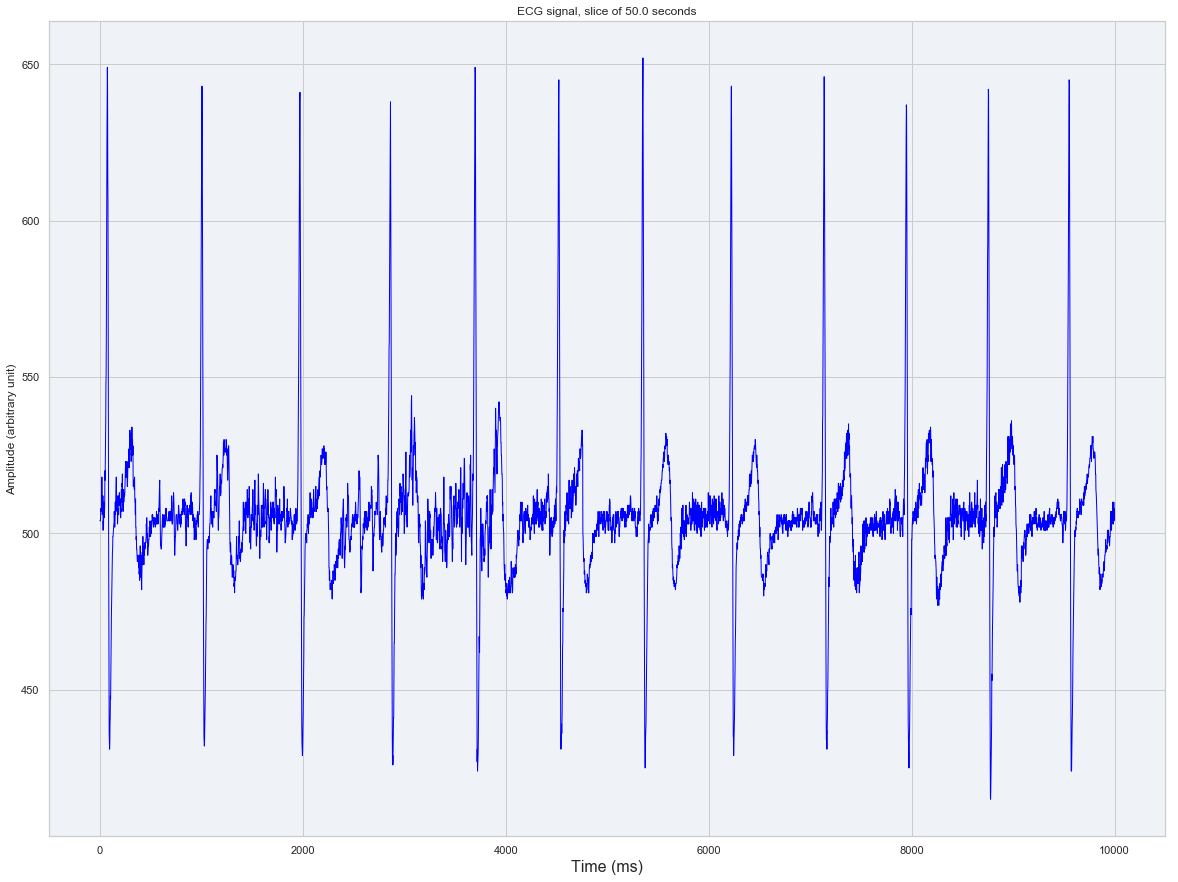

In [47]:
plt.figure(figsize=(20,15))
start = 0
stop = 5000
duration = duration = (stop - start) / 100 #freq
plt.title("ECG signal, slice of %.1f seconds" % duration)
plt.plot(df[start:stop].index, df[start:stop].heartrate, color="Blue", linewidth = 1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

In [48]:

# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for Bobbi sensor
settings = {}
settings['fs'] = 500

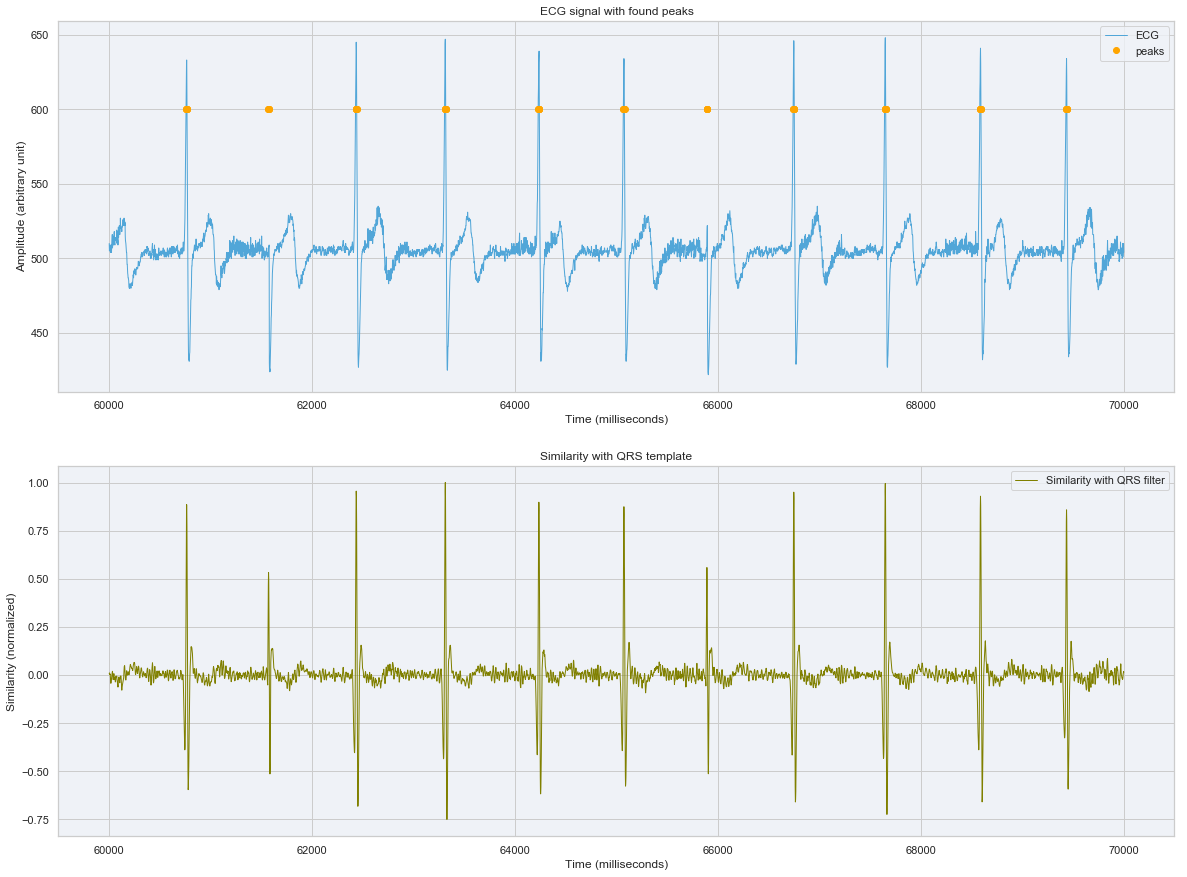

In [51]:

sampfrom = 60000
sampto = 70000
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (df.index >= start) & (df.index < stop) 
    ecg_slice = df.heartrate[cond_slice]

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
    
    # plot similarity
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(600, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")

(200500, 203000)

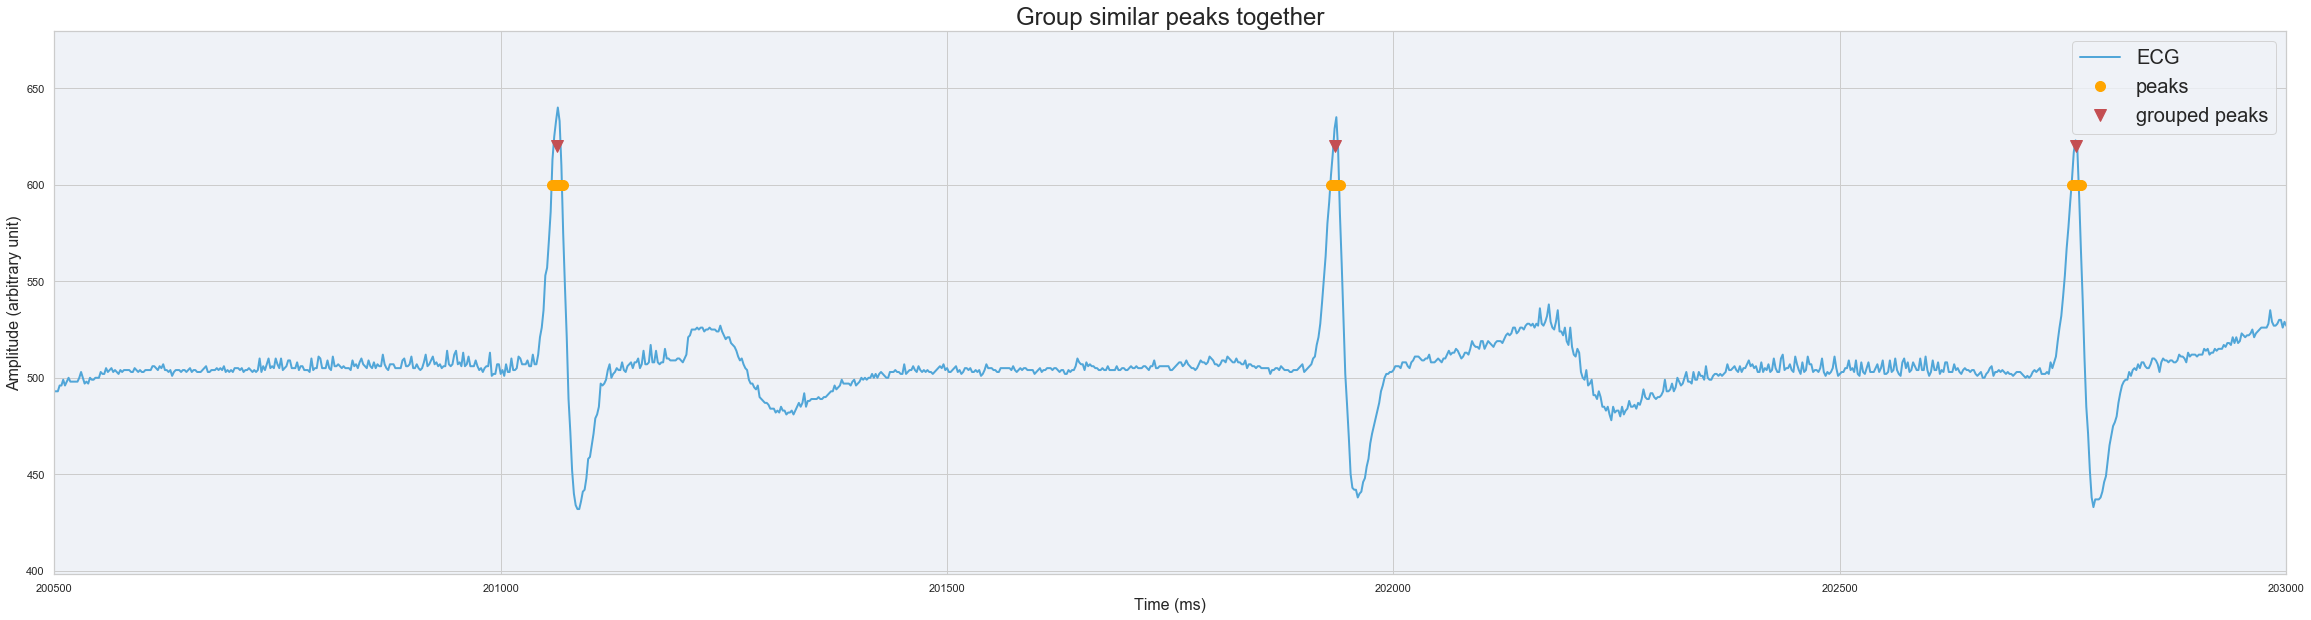

In [118]:
peak_groups, num_groups= label(np.diff(peaks)<5)
# get all peak index
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

# group peaks
grouped_peaks = group_peaks(peaks)
plt.figure(figsize=(40,10))
plt.title("Group similar peaks together", fontsize=24)
plt.plot(df.index, df.heartrate, label="ECG", color="#51A6D8", linewidth=2)
plt.plot(peaks, np.repeat(600, peaks.shape[0]), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(620, grouped_peaks.shape[0]), markersize=12, label="grouped peaks", color="r", marker="v", linestyle="None")
plt.legend(loc="upper right", fontsize=20)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
plt.gca().set_xlim(200500,203000)

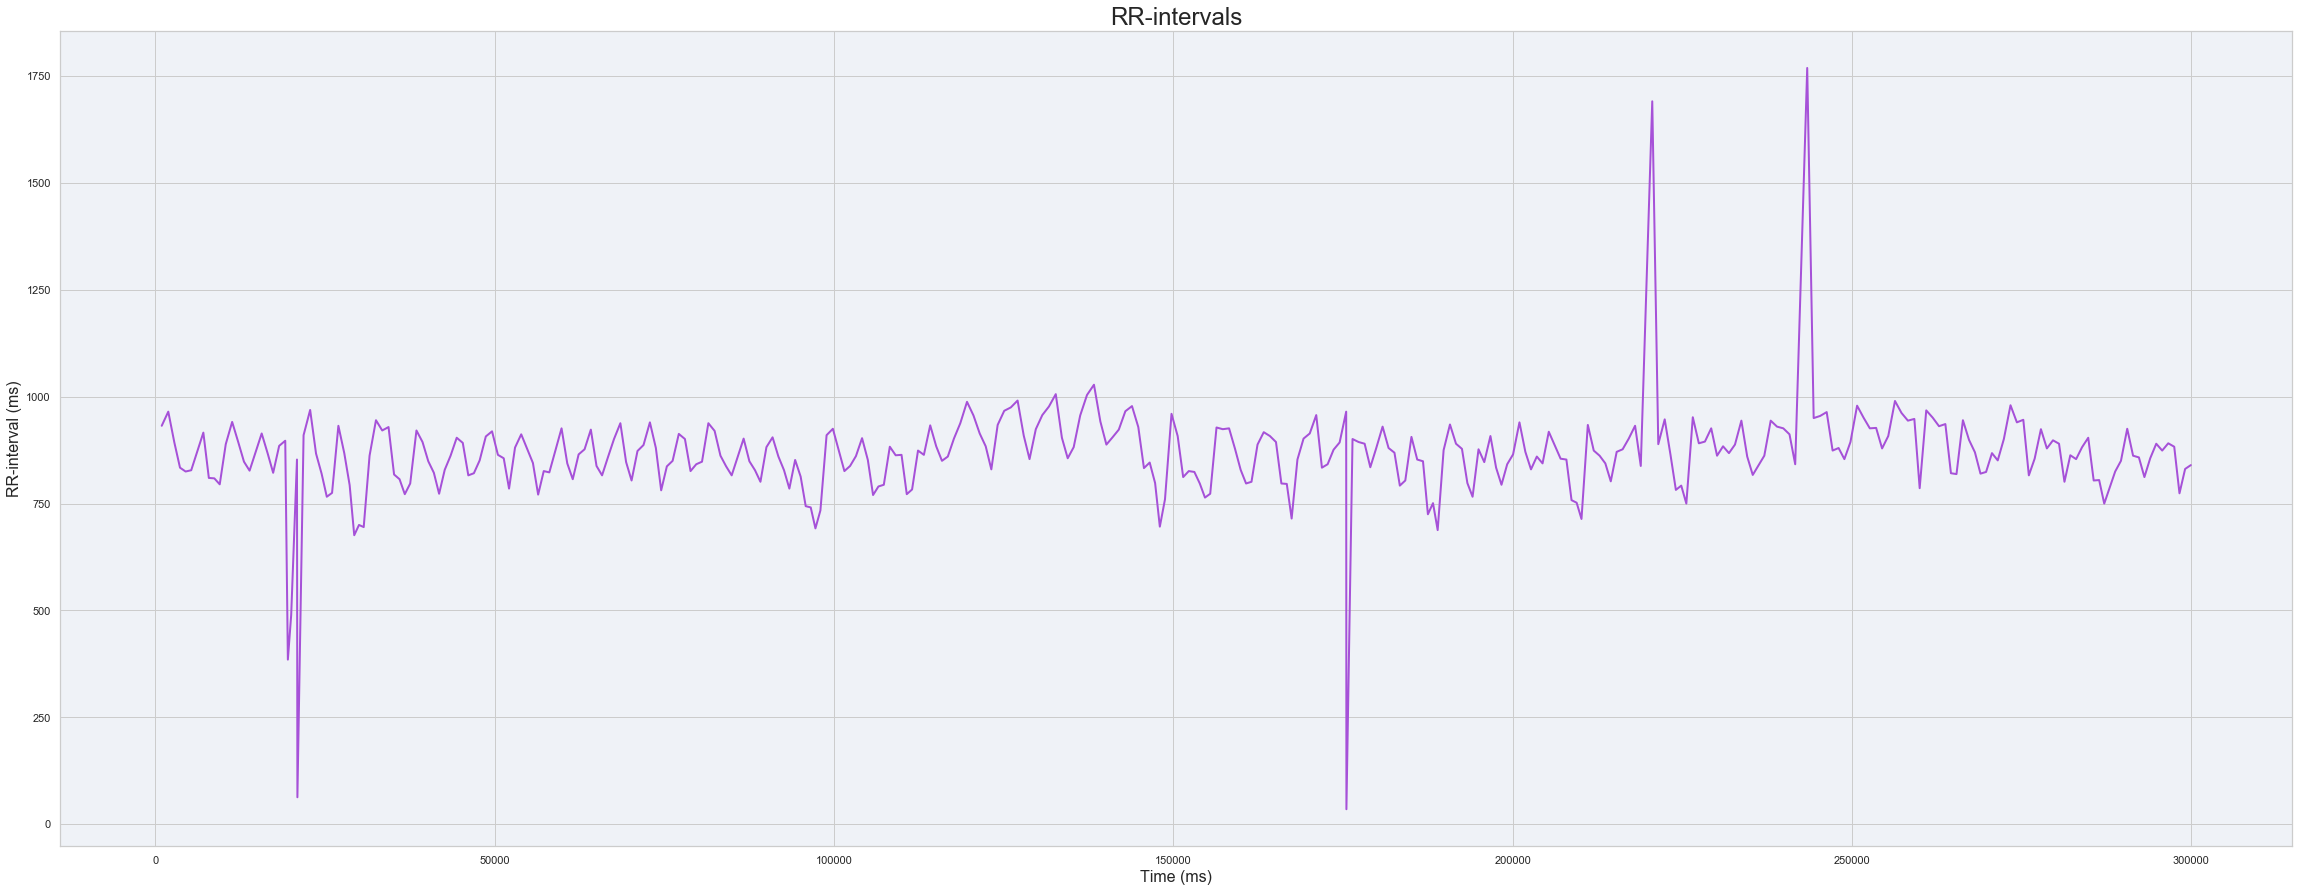

In [147]:
# detect peaks
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

# group peaks so we get a single peak per beat
grouped_peaks = group_peaks(peaks)

#sorted_grp_peaks = np.sort(grouped_peaks)
# the grouped peaks is the 
rr = np.diff(grouped_peaks)

plt.figure(figsize=(40, 15))
plt.title("RR-intervals", fontsize=24)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)
# rr is the difference between each peak, cummulate them to get the final ms 
plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8", linewidth=2)


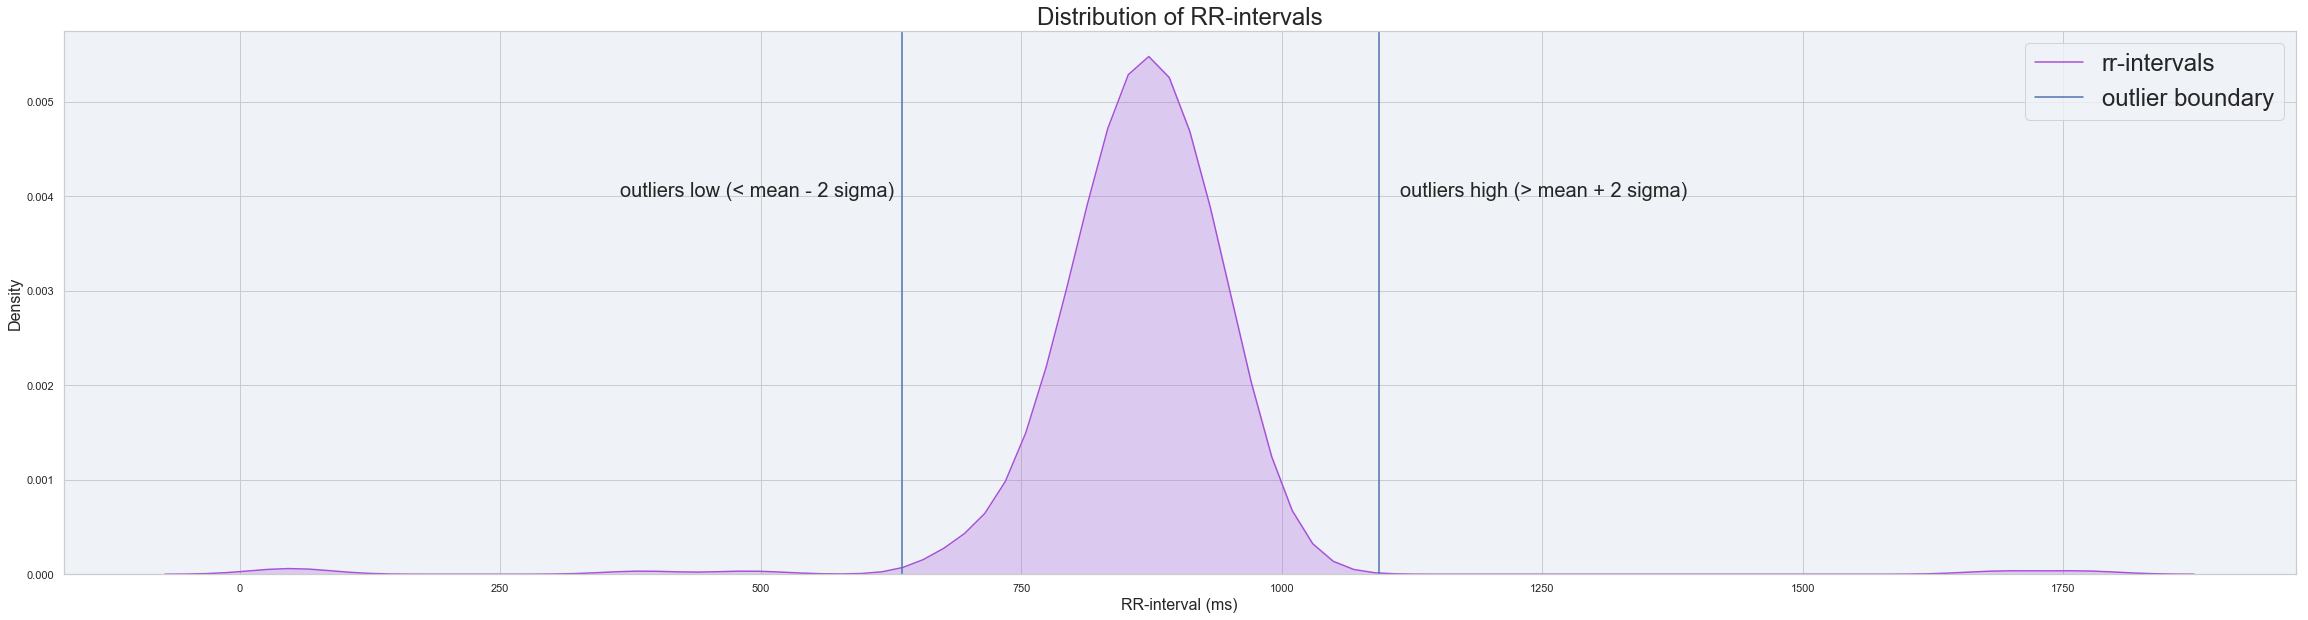

In [148]:
plt.figure(figsize=(40, 10))
plt.title("Distribution of RR-intervals", fontsize=24)
sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(rr)-2 * np.std(rr)
outlier_high = np.mean(rr)+2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 270, 0.004, "outliers low (< mean - 2 sigma)", fontsize=20)
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)", fontsize=20)

plt.xlabel("RR-interval (ms)", fontsize=16)
plt.ylabel("Density", fontsize=16)

plt.legend(fontsize=24)

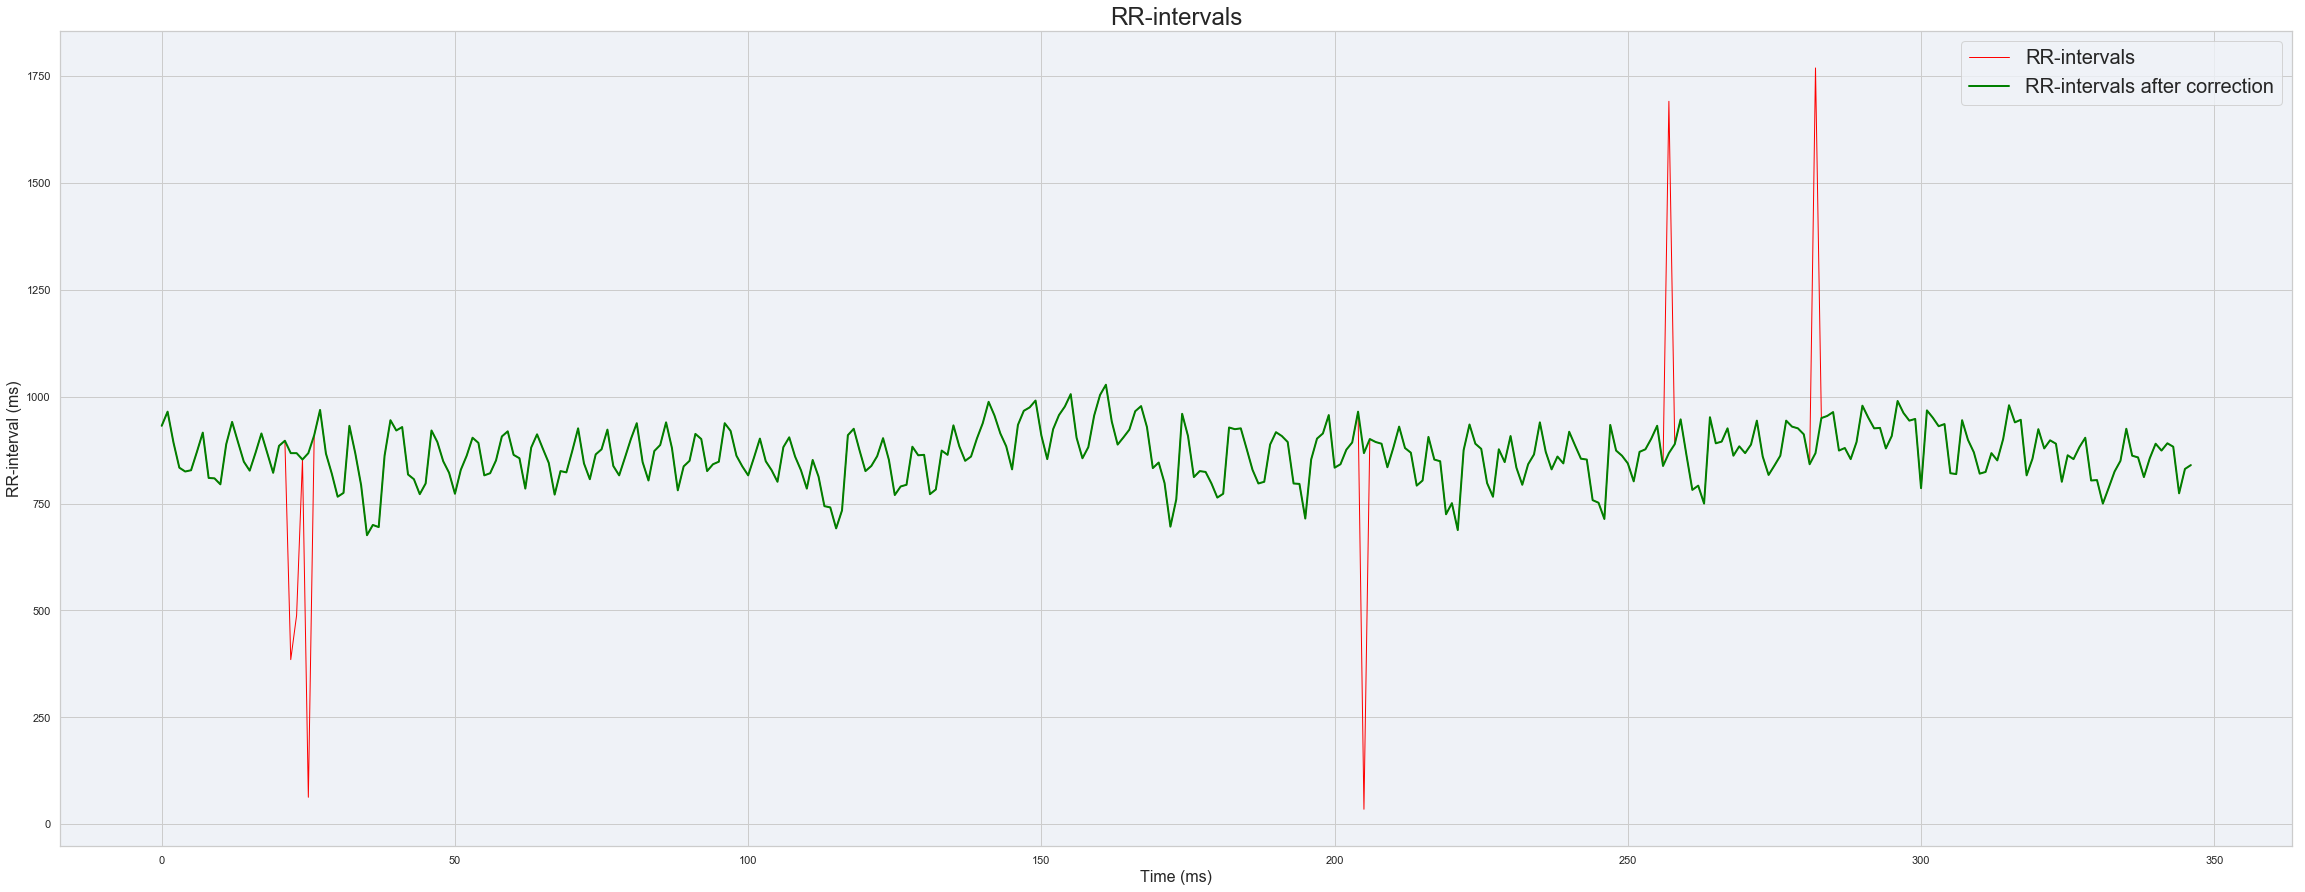

In [150]:
plt.figure(figsize=(40, 15))

rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals", fontsize=24)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)

plt.plot(rr, color="red", linewidth=1, label="RR-intervals")
plt.plot(rr_corrected, color="green", linewidth=2, label="RR-intervals after correction")
plt.legend(fontsize=20)

In [81]:
cond_slice = (df.index >= start) & (df.index < stop)
cond_slice[140500]

False

In [24]:
ecg_slice.head()

ms
60000    510
60002    505
60004    506
60006    507
60008    507
Name: heartrate, dtype: int64

In [3]:
mesadf = pd.read_csv(os.path.join(DATAPAHT,'edfcsv_256Hz.csv'),sep=";")

In [6]:
mesadf.head()

,Date,HH,MM,SS,EKG[mV],DHR[bpm]
0,1985/01/01,9,10,45.000000,0.024186,0.0
1,1985/01/01,9,10,45.003906,0.013962,0.0
2,1985/01/01,9,10,45.007812,0.008164,0.0
3,1985/01/01,9,10,45.011719,0.006027,0.0
4,1985/01/01,9,10,45.015625,0.001450,0.0


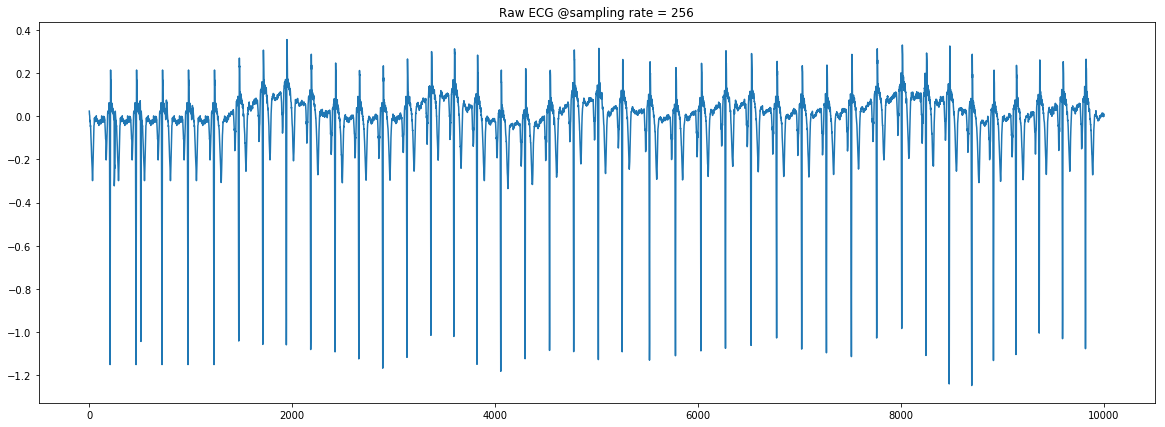

In [11]:
plt.figure(figsize=(20,10))
start = 0
stop = 5000
duration = (stop - start) / 256
plt.title("Raw ECG @sampling rate = "+ str(256))
plt.plot(data['EKG[mV]'][0:10000])

In [12]:
import neurokit as nk

ModuleNotFoundError: No module named 'cvxopt.base'

In [4]:
example_hrdata = hp.get_data(os.path.join(DATAPAHT,'ecg_int.csv'))

In [5]:
data.head()

,Date,HH,MM,SS,EKG[mV],DHR[bpm]
0,1985/01/01,9,10,45.000000,0.024186,0.0
1,1985/01/01,9,10,45.003906,0.013962,0.0
2,1985/01/01,9,10,45.007812,0.008164,0.0
3,1985/01/01,9,10,45.011719,0.006027,0.0
4,1985/01/01,9,10,45.015625,0.001450,0.0


In [6]:
data['timestamp'] = data['Date'].astype(str) + ' ' + data['HH'].astype(str) + ':' +data['MM'].astype(str)+ ':'+data['SS'].astype(str)

In [7]:
data.head()

,Date,HH,MM,SS,EKG[mV],DHR[bpm],timestamp
0,1985/01/01,9,10,45.000000,0.024186,0.0,1985/01/01 9:10:45.0
1,1985/01/01,9,10,45.003906,0.013962,0.0,1985/01/01 9:10:45.00390625
2,1985/01/01,9,10,45.007812,0.008164,0.0,1985/01/01 9:10:45.0078125
3,1985/01/01,9,10,45.011719,0.006027,0.0,1985/01/01 9:10:45.01171875
4,1985/01/01,9,10,45.015625,0.001450,0.0,1985/01/01 9:10:45.015625


In [8]:
data['Date_time'] = pd.to_datetime(data['timestamp'], format='%Y/%m/%d %H:%M:%S.%f')

In [24]:
data['Date_time'][1:2]

1   1985-01-01 09:10:45.003906250
Name: Date_time, dtype: datetime64[ns]

In [25]:
hr_list = data['EKG[mV]'][20000:50000].values

In [27]:
min(hr_list)

-1.75761043717098

In [87]:
plt.plot(hr_list)

AttributeError: module 'matplotlib' has no attribute 'plot'

In [85]:
working_data, measures = hp.process(hr_list,256,calc_freq=True)

ValueError: min() arg is an empty sequence

In [21]:
working_data, measures = hp.process(example_hrdata,100,calc_freq=True)

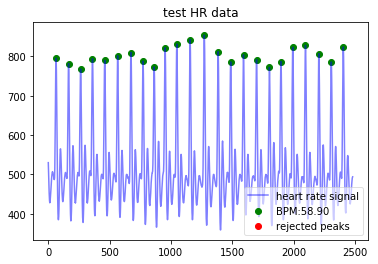

In [22]:
hp.plotter(working_data,measures,title='test HR data')